## Historical Regular Season NBA Elo Ratings

In this notebook, we will compute our simple Elo ratings for historical NBA regular seasons. For an introduction to Elo ratings in general, and a review of our simple NBA Elo ratings, please see [this previous post](http://practicallypredictable.com/2018/04/15/elo-ratings-for-nba-teams/).

In this notebook, we will compute the Elo rating for each NBA team as of the end of each regular season, going back to the 1996-97 NBA season. In an upcoming post, we will evaluate how well these end-of-season ratings would have predicted playoff series success. We will use this as a starting point for developing more advanced ratings systems.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:.3f}'.format

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', palette='colorblind')

In [3]:
import math
import operator
from datetime import date, datetime
from collections import OrderedDict

In [4]:
from tqdm import tqdm_notebook as tqdm

At the end of this notebook, we will examine the relationship between end-of-season Elo rating and team win percentage over the season. To do that, we will use the [`linear_model`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module from the [`scikit-learn`](http://scikit-learn.org/stable/index.html) package. This package should already be present in your Python sports analytics environment if you've [set up Python as we've previously recommended](http://practicallypredictable.com/2017/11/16/setting-up-python/).

In [5]:
from sklearn import linear_model

### A Better Framework for Elo Ratings

The introductory post on Elo ratings linked to [this Jupyter notebook](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/basketball/nba/notebooks/nba-simple_elo_ratings.ipynb). This notebook includes Python code to actually implement the simple Elo ratings.

We want to have a more general framework for implementing Elo ratings and, eventually, other rating systems. After all, we are going to be spending a lot of time with rating systems on this site. We are going to be studying simple Elo ratings to start, and examining ways to make better predictions of team performance as we build more complicated systems.

We want to make the Elo ratings code easier to use as we progress. Two major goals should be:

1. Our Elo ratings code easy to _reuse_ in different applications. This means we want to have as much code as possible sit in a package. The guiding principle is [**DRY**](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself): Don't repeat yourself.
2. Create a _modular_ framework, so we don't have to change a lot of code each time we test a different version of the ratings system.

We will implement an [object-oriented](https://en.wikipedia.org/wiki/Object-oriented_programming) framework for sports ratings systems, starting with Elo ratings. See [this notebook](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/basketball/nba/notebooks/prototyping-elo_ratings-object-oriented-framework.ipynb) for an in-depth explanation of the framework and the Python code.

Within this general framework, our simple NBA Elo ratings can be implemented in just a few dozen lines of code. [Here](https://github.com/practicallypredictable/posts/blob/master/basketball/nba/notebooks/nbaelo.py) is the Python code, which we can bring into this notebook using the `%load` notebook method.

In [6]:
# %load nbaelo.py
from enum import Enum, auto
from pracpred.ratings import elo

class SimpleNBAElo(elo.Updater):
    """Simple Elo ratings for NBA teams"""
    class GameType(Enum):
        REGULAR = auto()
        PLAYOFF = auto()

    def __init__(self, *, regular_season_hca=69, playoff_hca=93):
        super().__init__(
            calculator=elo.LogisticCalculator(),
            multiplier=elo.ConstantMultiplier(constant=20)
        )
        self._reg_hca = regular_season_hca
        self._post_hca = playoff_hca
    
    @property
    def regular_season_hca(self):
        return self._reg_hca
    
    @property
    def playoff_hca(self):
        return self._post_hca

    def update(self, *, game_type, home_team, outcome, elo1, elo2):
        """Update Elo ratings"""
        if outcome == elo.MatchOutcome.DRAW:
            raise ValueError('no draws in basketball')
        if game_type == self.GameType.REGULAR:
            hca = self.regular_season_hca
        elif game_type == self.GameType.PLAYOFF:
            hca = self.playoff_hca
        else:
            raise ValueError('invalid game type', game_type)
        if home_team == 1:
            adjustment = hca
        elif home_team == 2:
            adjustment = -hca
        else:
            raise ValueError('invalid home team', home_team)
        return super().update(outcome=outcome, elo1=elo1, elo2=elo2, adjustment=adjustment)

Once we've loaded the Elo ratings code, we need to create an instance of the ratings class to do the actual computations. Here's an example.

In [7]:
simple_elo = SimpleNBAElo()

In [8]:
simple_elo.update(
    game_type=SimpleNBAElo.GameType.REGULAR,
    home_team=1,
    outcome=elo.MatchOutcome.WIN1,
    elo1=1500,
    elo2=1500,
)

(1508.039724684613, 1491.960275315387)

In [9]:
simple_elo.regular_season_hca

69

In [10]:
simple_elo.calculator.win_probs(elo1=1500, elo2=1500, adjustment=simple_elo.regular_season_hca)

(0.5980137657693436, 0.40198623423065644)

Notice that a positive Elo adjustment (for home court advantage, in this case) acts similar to an increase the first team's rating or a decrease in the second team's rating (and vice versa, for a negative Elo adjustment). See the [prototyping notebook](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/basketball/nba/notebooks/prototyping-elo_ratings-object-oriented-framework.ipynb) for more details and examples.


### Historical Regular Season NBA Games

We will use the [`pracnbastats`](https://pypi.org/project/pracnbastats/) package I developed for scraping [stats.nba.com](http://stats.nba.com/). You can install this package in your sports analytics Python environment by executing `pip install pracnbastats` in Terminal (on Mac or Linux computers) or at the Anaconda Prompt in Windows.

In [11]:
import pracnbastats as nba

In [12]:
from pathlib import Path

This code assumes the existence of a directory to hold scraped NBA data. You can create and name this directory however you want, and adjust the code in the cell below to suit your preferences.

In [13]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / 'data'
STATS_DIR = DATA_DIR / 'stats-nba-com'
OUTPUT_DIR = DATA_DIR / 'prepared'

To scrape data from [stats.nba.com](http://stats.nba.com/), you need to specify a user agent. Below is the user agent I used. You can find your own user agent by searching for "my user agent" in Google.

In [14]:
USER_AGENT = (
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) '
    'AppleWebKit/537.36 (KHTML, like Gecko) '
    'Chrome/66.0.3359.139 Safari/537.36'
)

Now let's get all of the historical regular season NBA match ups since the 1996-97 season.

In [15]:
session = nba.scrape.NBASession(user_agent=USER_AGENT)

In [16]:
store = nba.store.FlatFiles.CSV(path=STATS_DIR)

In [17]:
scraper = nba.scrape.NBAScraper(session=session, store=store)

In [18]:
nba_reg = {season.start_year: nba.team.BoxScores(
    scraper=scraper,
    season=season,
) for season in tqdm(nba.params.Season.stats_seasons())}
len(nba_reg)

22

### Computing End-of-Season Elo Ratings

Now we are ready to compute each team's Elo ratings at the end of each regular season. We will follow a similar approach as in the introductory post:

1. Set each team's rating to the league-wide average of 1500 at the beginning of each regular season.
2. Analyze each match up in chronological order. Update the Elo ratings of the winning and losing teams, applying a regular season home court advantage of 69 Elo rating points. (For a refresher about home court advantage in the Elo rating framework, please see the [introductory post](http://practicallypredictable.com/2018/04/15/elo-ratings-for-nba-teams/#computing-the-home-court-adjustment)).
3. Once we get to the end of the regular season, save the final ratings for each teach.

The code below actually computes a [time series](https://en.wikipedia.org/wiki/Time_series) of each team's rating over the course of the regular season. In this notebook we won't use the time series however. We'll only use the final Elo rating at the end of the regular season.

#### Initialize the Elo Rating to 1500 at Season Start

The first function gets the list of team abbreviations for a particular season, and sets the Elo ratings of each team to the league-wide average of 1500.

In [19]:
def season_start_elos(*, box_scores, season):
    """Start all teams at 1500 Elo rating at beginning of regular season"""
    team_abbrs = box_scores[season].team_records['team_abbr'].unique().tolist()
    return {abbr: 1500 for abbr in team_abbrs}

#### Update Elo Ratings over Regular Season

The next function loops through each game during the season in chronological order, updating the Elo ratings for the winning and losing teams.

In [20]:
def nba_season_elos(*, updater, box_scores, start_elos):
    """Elo ratings at end of, and over the course of, an NBA regular season"""
    latest_elos = start_elos
    elo_history = []
    for game in box_scores.matchups.sort_values(by='date', ascending=True).itertuples():
        home_abbr = game.team_abbr_h
        road_abbr = game.team_abbr_r
        # Home team is team #1, road team is team #2
        outcome = elo.MatchOutcome.WIN1 if game.hr_winner == 'H' else elo.MatchOutcome.WIN2
        home_elo = latest_elos[home_abbr]
        road_elo = latest_elos[road_abbr]
        (new_home_elo, new_road_elo) = updater.update(
            game_type=SimpleNBAElo.GameType.REGULAR,
            home_team=1,
            outcome=outcome,
            elo1=home_elo,
            elo2=road_elo,
        )
        home_record = OrderedDict({
            'date': game.date,
            'game_id': game.game_id,
            'team_abbr': home_abbr,
            'elo': new_home_elo,
        })
        elo_history.append(home_record)
        road_record = OrderedDict({
            'date': game.date,
            'game_id': game.game_id,
            'team_abbr': road_abbr,
            'elo': new_road_elo,
        })
        elo_history.append(road_record)
        latest_elos[home_abbr] = new_home_elo
        latest_elos[road_abbr] = new_road_elo
    return latest_elos, elo_history

#### Get End-of-Season Elo Ratings

This function calls the above two functions for a given season. It saves the end-of-season Elo ratings for each team in a `DataFrame`.

In [21]:
def season_end_elos(*, updater, box_scores, season):
    """End of regular season Elo ratings for given NBA season"""
    reg_end_elos, elo_history = nba_season_elos(
        updater=updater,
        box_scores=box_scores[season],
        start_elos=season_start_elos(box_scores=box_scores, season=season),
    )
    df = (
        pd.DataFrame.from_dict(reg_end_elos, orient='index')
        .reset_index()
        .rename(columns={
            'index': 'team_abbr',
            0: 'reg_end_elo',
        })
    )
    df['season'] = season
    df = df[['season', 'team_abbr', 'reg_end_elo']]
    return df.sort_values(by=['reg_end_elo'], ascending=False).reset_index(drop=True)

Let's test the function out on this year's regular season.

In [22]:
season_end_elos(updater=simple_elo, box_scores=nba_reg, season=2017)

,season,team_abbr,reg_end_elo
0,2017,HOU,1718.759
1,2017,TOR,1642.510
2,2017,PHI,1637.861
3,2017,UTA,1616.204
4,2017,POR,1595.066
5,2017,GSW,1590.396
6,2017,NOP,1587.252
7,2017,BOS,1586.176
8,2017,IND,1584.657
9,2017,OKC,1580.235


As an aside, here is a function that saves the history of team Elo ratings over the course of the regular season. We won't use this anymore in this notebook.

In [23]:
def season_elo_history(*, updater, box_scores, season):
    """Elo ratings over course of a regular NBA season"""
    reg_end_elos, elo_history = nba_season_elos(
        updater=updater,
        box_scores=box_scores[season],
        start_elos=season_start_elos(box_scores=box_scores, season=season),
    )
    df = pd.DataFrame(elo_history)
    df['season'] = season
    df = df[['season', 'date', 'game_id', 'team_abbr', 'elo']]
    return df

In [24]:
season_elo_history(updater=simple_elo, box_scores=nba_reg, season=1996).head()

,season,date,game_id,team_abbr,elo
0,1996,1996-11-01,29600002,NJN,1488.040
1,1996,1996-11-01,29600002,CLE,1511.960
2,1996,1996-11-01,29600013,GSW,1488.040
3,1996,1996-11-01,29600013,LAC,1511.960
4,1996,1996-11-01,29600001,BOS,1488.040


#### Putting It All Together

Now we can write a function which loops over all of the NBA regular seasons since 1996-97, and calls the above function to get each season's team ratings.

In [25]:
def nba_season_end_elos(
        *, updater, box_scores,
        start_year=nba.params.MIN_YEAR,
        end_year=nba.params.Season.current_start_year()):
    """Historical end of regular season NBA Elo ratings"""
    reg_elos = {
        season: season_end_elos(
            updater=updater,
            box_scores=box_scores,
            season=season,
        ) for season in tqdm(range(start_year, end_year+1))
    }
    return pd.concat(reg_elos[season] for season in reg_elos).reset_index(drop=True)

In [26]:
reg_elos = nba_season_end_elos(updater=simple_elo, box_scores=nba_reg)
len(reg_elos)

652

In [27]:
reg_elos.head()

,season,team_abbr,reg_end_elo
0,1996,CHI,1720.096
1,1996,UTA,1713.001
2,1996,MIA,1661.044
3,1996,NYK,1638.366
4,1996,ATL,1625.877


#### Save Data to CSV File

Let's save the regular season final Elo ratings in a CSV file. We will use these ratings in a future post to try to predict playoff series outcomes.

In [28]:
csvfilename = 'nba-reg_season_final_elos-1996_2017.csv'
csvfile = OUTPUT_DIR.joinpath(csvfilename)
reg_elos.to_csv(csvfile, index=False)

### Analyzing Simple NBA Elo Ratings by Season

Let's look at the overall history of our regular season Elo ratings. Here is a box plot of ratings grouped by season.

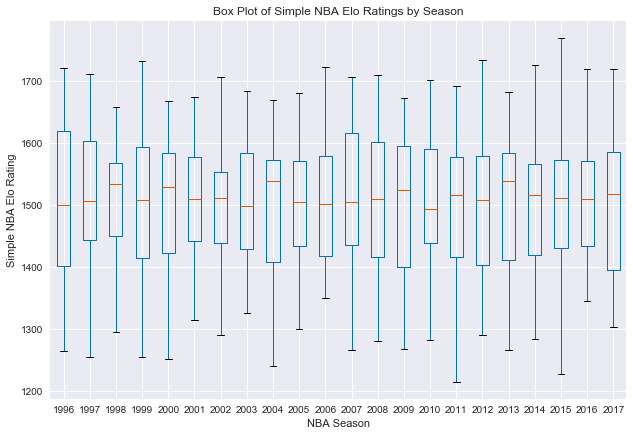

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
reg_elos.boxplot(by='season', ax=ax)
ax.set_xlabel('NBA Season')
ax.set_ylabel('Simple NBA Elo Rating')
ax.set_title('Box Plot of Simple NBA Elo Ratings by Season')
plt.suptitle('')  # Get ride of pandas-generated title
plt.show()

In each season, the average rating is 1500 across the league. The median value (the red line in the above plot) is always relatively close to 1500, but varies from season to season.

The range of ratings also varies by season. Team ratings tend to fall between 1300 and 1700, but some teams fall outside this range most seasons. Each season's [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) (the rectangles in the plot above) are typically between ratings of 1400 and 1600.

You can see the raw numbers by season using the `pandas` [`groupby()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) and [`describe()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) methods.

In [30]:
reg_elos.groupby(['season']).describe()

reg_end_elo                                                       \
             count     mean     std      min      25%      50%      75%   
season                                                                    
1996        29.000 1500.000 133.816 1264.287 1401.154 1499.136 1619.410   
1997        29.000 1500.000 137.343 1254.947 1443.247 1505.427 1603.552   
1998        29.000 1500.000  88.744 1295.498 1450.271 1533.991 1567.225   
1999        29.000 1500.000 115.930 1254.661 1413.732 1508.520 1593.142   
2000        29.000 1500.000 115.878 1252.482 1421.870 1529.261 1583.359   
2001        29.000 1500.000  97.604 1314.556 1441.604 1509.143 1577.432   
2002        29.000 1500.000 104.596 1290.449 1438.489 1511.453 1553.473   
2003        29.000 1500.000 102.158 1325.869 1429.465 1497.491 1584.181   
2004        30.000 1500.000 115.501 1240.656 1408.011 1538.512 1572.014   
2005        30.000 1500.000  93.619 1299.343 1433.711 1505.208 1571.226   
2006        30.000 1500.000  97.130 1349.978 1417.886 1501.434 1578.454   
2007        30.000 1500.000 120.402 1266.096 1436.014 1505.095 1616.076   
2008        30.000 1500.000 116.797 1281.600 1415.617 1508.840 1600.448   
2009        30.000 1500.000 115.245 1268.015 1400.124 1523.729 1595.447   
2010        30.000 1500.000 109.932 1282.229 1438.162 1494.067 1589.749   
2011        30.000 1500.000 104.605 1215.423 1416.239 1516.531 1577.007   
2012        30.000 1500.000 111.569 1289.874 1403.542 1507.503 1578.987   
2013        30.000 1500.000 114.421 1266.679 1411.769 1538.540 1584.158   
2014        30.000 1500.000 117.754 1283.289 1419.555 1516.542 1565.731   
2015        30.000 1500.000 120.500 1226.965 1429.898 1511.040 1572.430   
2016        30.000 1500.000  92.102 1344.988 1433.282 1509.769 1570.829   
2017        30.000 1500.000 110.815 1303.276 1395.494 1517.226 1585.797   

                 
            max  
season           
1996   1720.096  
1997   1710.590  
1998   1658.079  
1999   1731.521  
2000   1666.640  
2001   1673.972  
2002   1705.225  
2003   1683.075  
2004   1669.405  
2005   1680.083  
2006   1722.298  
2007   1705.223  
2008   1709.253  
2009   1672.527  
2010   1701.611  
2011   1691.552  
2012   1732.481  
2013   1682.227  
2014   1724.481  
2015   1768.693  
2016   1718.294  
2017   1718.759

This function creates a table showing the best and worst teams (as defined by our simple Elo ratings) for each season.

In [31]:
def best_worst_teams(elos):
    best_teams = (
        elos
        .sort_values(by=['reg_end_elo'], ascending=False)
        .drop_duplicates(['season'])
        .sort_values(by=['season'])
        .reset_index(drop=True)
    )
    worst_teams = (
        elos
        .sort_values(by=['reg_end_elo'], ascending=True)
        .drop_duplicates(['season'])
        .sort_values(by=['season'])
        .reset_index(drop=True)
    )
    df = best_teams.merge(worst_teams, on=['season'], suffixes=['_best', '_worst'])
    df['elo_range'] = df['reg_end_elo_best'] - df['reg_end_elo_worst']
    first_cols = ['season']
    cols = first_cols + [col for col in df.columns if col not in first_cols]
    return df[cols]

In [32]:
best_worst_teams(reg_elos)

,season,team_abbr_best,reg_end_elo_best,team_abbr_worst,reg_end_elo_worst,elo_range
0,1996,CHI,1720.096,VAN,1264.287,455.809
1,1997,UTA,1710.590,DEN,1254.947,455.642
2,1998,SAS,1658.079,VAN,1295.498,362.581
3,1999,LAL,1731.521,LAC,1254.661,476.861
4,2000,SAS,1666.640,GSW,1252.482,414.157
5,2001,SAS,1673.972,GSW,1314.556,359.417
6,2002,SAS,1705.225,DEN,1290.449,414.776
7,2003,SAS,1683.075,ORL,1325.869,357.207
8,2004,PHX,1669.405,ATL,1240.656,428.748
9,2005,SAS,1680.083,POR,1299.343,380.739


### Elo Ratings and Team Win Percentage

Every time a team wins, its Elo rating increases. It may increase a lot, if the win is a major upset (based upon the relative team ratings prior to the game). Under the logic of Elo ratings, an upset either means the underdog was very lucky, or is actually better than suggested by the prior ratings. Either way, subsequent team performance will either confirm the improved Elo rating, or show that the upset was just a fluke. The hope is that Elo ratings will converge over time to an accurate assessment of the team's true strength.

Since teams that win more often have higher Elo ratings, there should be a strong relationship between win percentage on the season and the season-ending Elo rating. Let's see if that is in fact the case.

First, let's compute win percentages for each team for every regular NBA season in our data set. We will construct a new `DataFrame` holding the Elo rating and win percentage at the end of each regular season, for each team.

In [33]:
def team_win_pcts(box_scores):
    return pd.concat([
        box_scores[season].team_records[['season', 'team_abbr', 'win_pct']]
        for season in tqdm(box_scores)
    ])

In [34]:
def merge_team_records(elos, box_scores):
    df = elos.merge(
        team_win_pcts(box_scores),
        on=['season', 'team_abbr'],
    )
    return df

In [35]:
df = merge_team_records(reg_elos, nba_reg)
len(df)

652

In [36]:
df.head()

,season,team_abbr,reg_end_elo,win_pct
0,1996,CHI,1720.096,0.841
1,1996,UTA,1713.001,0.780
2,1996,MIA,1661.044,0.744
3,1996,NYK,1638.366,0.695
4,1996,ATL,1625.877,0.683


Here is a scatter plot of the end-of-season Elo rating versus the win percentage.

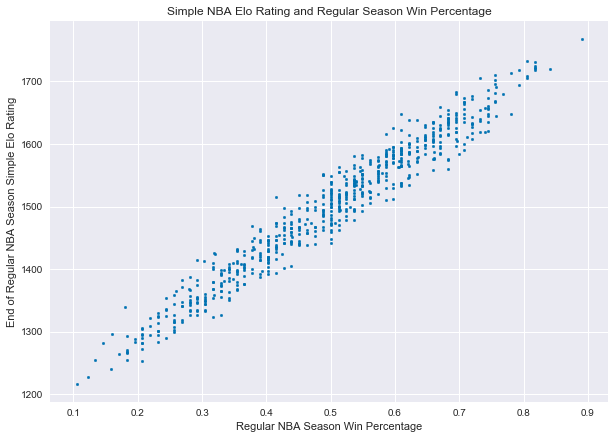

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(kind='scatter', x='win_pct', y='reg_end_elo', ax=ax, s=7)
ax.set_xlabel('Regular NBA Season Win Percentage')
ax.set_ylabel('End of Regular NBA Season Simple Elo Rating')
ax.set_title('Simple NBA Elo Rating and Regular Season Win Percentage')
plt.show()

#### Fitting a Line to the Scatter Plot

The 652 data points in the scatter plot above seem to have an approximately [linear](https://en.wikipedia.org/wiki/Linearity) relationship. That is, the [slope](https://en.wikipedia.org/wiki/Slope) of the relationship between win percentage and Elo rating seems to be roughly constant.

We can fit a straight line to the data points using [linear regression](https://en.wikipedia.org/wiki/Linear_regression). We will attempt to explain the end-of-season Elo rating in terms of the season win percentage. This situation, where one variable (the _explanatory variable_) is used to explain another variable (the _dependent variable_) using a straight line is the simplest case of linear regression. Appropriately enough, this is called [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression).

We can easily perform linear regression in Python using the [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) `class` from the [`scikit-learn`](http://scikit-learn.org/stable/index.html) package.

First, let's prepare the data for the regression. Our explanatory variable will be called `X` and will be the team win percentage. Our dependent variable will be called `y` and will be the end-of-season Elo rating. Notice that we are calling the `pandas` [`values()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.values.html) method to extract each of the two columns of the `DataFrame` as a [`NumPy`](http://www.numpy.org/) [`array`](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html).

In [38]:
X = df['win_pct'].values.reshape(-1, 1)
y = df['reg_end_elo'].values

Now let's fit the linear regression model.

In [39]:
lm = linear_model.LinearRegression()
fit = lm.fit(X, y)

#### Slope

The `fit` object contains all the information about the straight line that best fits our data set. Let's see the slope of the line of best fit.

In [40]:
fit.coef_

array([ 690.02119094])

According to this estimated linear regression model, every 10% increase in season win percentage corresponds to an Elo rating increase of roughly 69 points.

In a normal 82-game regular NBA season, each win is worth 1.22% in win percentage. Therefore, each regular season win contributes roughly 8.3 points towards the team's end-of-season Elo rating.

#### Intercept

Now let's look at the intercept of the estimated line of best fit.

In [41]:
fit.intercept_

1154.9879705008948

According to this estimated linear regression model, a team with no wins would correspond to an Elo rating of approximately 1155.

#### Predicting Elo Rating from Win Percentage

We can use the slope and intercept of the fitted line to predict the end-of-season Elo rating, given the regular season win percentage.

In [42]:
def elo_predictor(fit):
    def wrapper(win_pct):
        return fit.intercept_ + (win_pct * fit.coef_[0])
    return wrapper

In [43]:
pred_elo = elo_predictor(fit)

In [44]:
pred_elo(0.5)

1499.9985659692277

As expected, this model predicts that a team with a .500 record will have an Elo rating equal to the league-wide average value of 1500. Let's see what Elo rating a mythical undefeated team would be awarded.

In [45]:
pred_elo(1)

1845.0091614375606

#### R-squared

We can use the `score()` method to help understand how well the straight line represents the overall data set.

In [46]:
fit.score(X, y)

0.95298626039136847

The `score()` method calculates the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) statistic for the regression. The coefficient of determination is also commonly called the "R-squared" of a regression. The simplest explanation of R-squared is the percentage of variation in the data explained by the fit. If all of the data points lie exactly on the line, then the R-squared is 100%. If there isn't a strong linear relationship between the variables, the R-squared will be close to zero.

In this case, the R-squared is approximately 95%, which suggests that there is a reasonably strong linear relationship between season win percentage and end-of-season Elo ratings.

#### Why Is This Interesting?

You may be wondering at this why we should even care to examine the relationship between win percentage and Elo ratings. After all, we compute Elo ratings from wins and losses, so they have to be related, right?

It is true that there has to be some relationship between win percentage and Elo ratings, but there is no obvious reason that the relationship has to be _linear_. After all, Elo ratings depend on things other than just the number of wins and losses. For example, they depend on the ratings of the opponents. Therefore, strength of schedule matters for each team. The fact that the NBA plays a relatively balanced regular season schedule is probably related to the fact that the empirical relationship between win percentage and Elo ratings is approximately linear.

#### Plotting the Fit

To conclude, let's plot the line of best fit on our scatter plot.

First, we need to generate the model predictions for each explanatory variable. Since our model is a simple linear regression, the predictions will all lie on the line of best fit.

In [47]:
predictions = lm.predict(X)

Now we can just plot the data again, but add in the line of best fit.

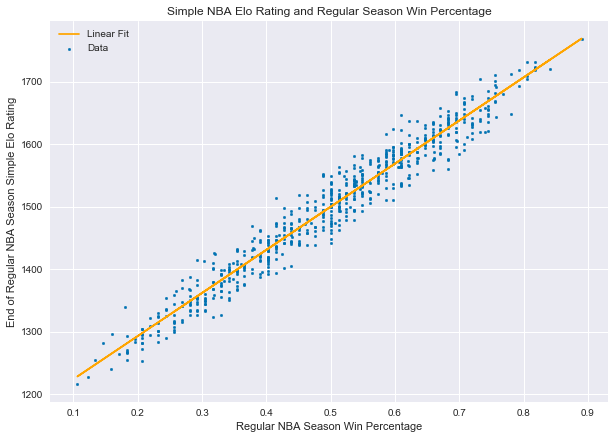

In [48]:
fig, ax = plt.subplots(figsize=(10, 7))
df.plot(kind='scatter', x='win_pct', y='reg_end_elo', label='Data', ax=ax, s=7)
ax.plot(X, predictions, label='Linear Fit', color='orange')  # line of best fit
ax.set_xlabel('Regular NBA Season Win Percentage')
ax.set_ylabel('End of Regular NBA Season Simple Elo Rating')
ax.set_title('Simple NBA Elo Rating and Regular Season Win Percentage')
ax.legend(loc='upper left')
plt.show()

#### Predicting Regular Season Records from Elo Ratings

We can turn the estimated linear relationship around to predict a regular season record, given an Elo rating. We need to be a bit careful in doing this, for two reasons:

1. Win percentages must be between 0 and 1. We can't plug in Elo ratings that would predict impossible win percentages.
2. The historical data only have season win percentages between 10% and 90%. You can also see from the plot that most teams have between 20% and 80% season win percentages. It's always dangerous to make predictions that extrapolate outside the range of observed data.

With these caveats in mind, here's a function that will predict the regular season record given the end-of-season Elo rating.

In [49]:
def record_predictor(fit, season_games=82):
    def wrapper(elo):
        if elo < fit.intercept_ or elo > fit.intercept_ + fit.coef_:
            raise ValueError(f'invalid Elo rating {elo}')
        win_pct = (elo - fit.intercept_) / fit.coef_[0]
        wins = int(round(season_games*win_pct))
        return wins, season_games - wins
    return wrapper

In [50]:
pred_record = record_predictor(fit)

In [51]:
pred_record(1500)

(41, 41)

In [52]:
pred_record(1700)

(65, 17)

In [53]:
pred_record(1300)

(17, 65)

Because of the empirical linear relationship, we see that 200 Elo rating points are worth approximately 24 regular season games. This is just the same 8.3 Elo rating points per win (for a normal 82-game NBA regular season) that we discovered above.